In [103]:
from global_config import logger, cfg, model_cfg
import numpy as np
import pandas as pd
import csv
import os
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve
import json
import ast
from mpl_toolkits.basemap import Basemap


In [104]:
csv_path = os.path.join(cfg.paths.output_folder,'alexnet',  '231116_152231', 'alexnet_predictions.csv')
pandas_df = pd.read_csv(csv_path, sep=',', header='infer', index_col='index')

In [105]:
def get_events_within_distance_radius(df, radius_km):
    """
    Returns a list of events within a given radius in km
    :param df: pandas dataframe
    :param radius_km: radius in km
    :return: list of events
    """
    df = df[df['distance'] <= radius_km]
    return df

def filter_by_prediction(df, prediction, use_detector=False):
    """
    Returns a DataFrame of events with a given prediction.
    :param df: pandas DataFrame
    :param prediction: The prediction to filter by
    :param use_detector: If True, filter by 'detector_prediction' instead of 'predicted'
    :return: pandas DataFrame
    """
    column_name = 'detector_prediction' if use_detector else 'predicted'
    return df[df[column_name] == prediction]

def filter_by_not_prediction(df, prediction, use_detector=False):
    """
    Returns a DataFrame of events not matching a given prediction.
    :param df: pandas DataFrame
    :param prediction: The prediction to filter by
    :param use_detector: If True, filter by 'detector_prediction' instead of 'predicted'
    :return: pandas DataFrame
    """
    column_name = 'detector_prediction' if use_detector else 'predicted'
    return df[df[column_name] != prediction]

def filter_by_true_label(df, label, use_detector=False):
    """
    Returns a DataFrame of events with a given true label.
    :param df: pandas DataFrame
    :param label: The true label to filter by
    :param use_detector: If True, filter by 'detector_true' instead of 'true'
    :return: pandas DataFrame
    """
    column_name = 'detector_true' if use_detector else 'true'
    return df[df[column_name] == label]


def get_uncertain_events(df, lower_bound, upper_bound, output_type):
    """
    Returns a list of events with a prediction probability within a given range (lower_bound, upper_bound)
    :param df: pandas dataframe
    :param lower_bound: lower bound
    :param upper_bound: upper bound
    :param output_type: one of classifier or detector
    :return: df
    """
    return df[(df[f'probability_{output_type}'] >= lower_bound) & (df[f'probability_{output_type}'] <= upper_bound)]

def add_detector_pred(df, threshold=0.5):
    """
    Converts a classifier output to a detector output
    :param df: pandas dataframe
    :param threshold: threshold
    :return: df
    """
    # Create a new column based on the condition
    df['detector_prediction'] = df['probability_detector'].apply(lambda x: 'event' if x >= threshold else 'noise')
    
    return df

def add_detector_true(df):
    """
    Adds a detector_true column to the dataframe
    :param df: pandas dataframe
    :return: df
    """
    df['detector_true'] = df['true'].apply(lambda x: 'noise' if x == 'noise' else 'event')
    return df

def filter_true_vs_predicted(df, true, predicted, use_detector=False):
    """
    Filters the DataFrame by true label and predicted label.
    :param df: pandas DataFrame
    :param true: True label
    :param predicted: Predicted label
    :param use_detector: If True, filter by detector outputs instead of normal true and predicted
    :return: pandas DataFrame
    """
    true_column = 'detector_true' if use_detector else 'true'
    pred_column = 'detector_prediction' if use_detector else 'predicted'
    return df[(df[true_column] == true) & (df[pred_column] == predicted)]


def add_lat_lon_mag(df):
    """
    Adds latitude, longitude, and magnitude columns to the dataframe.
    :param df: pandas dataframe
    :return: pandas dataframe with additional lat, lon, and mag columns
    """
    for index, row in df.iterrows():
        if row["true"] != "noise":
            meta = row["metadata"]
            # If meta is a string, convert it to a dictionary using ast.literal_eval
            if isinstance(meta, str):
                try:
                    meta = ast.literal_eval(meta)
                except ValueError:
                    print(f"Error processing metadata at index {index}: {meta}")
                    continue  # Skip this row and continue with the next one

            # Now we can be sure meta is a dictionary and access its contents
            lat = meta["origins"][0]["latitude"]
            lon = meta["origins"][0]["longitude"]
            # Check if 'magnitudes' is not empty and 'mag' key exists
            mag = meta["magnitudes"][0]["mag"] if meta["magnitudes"] and "mag" in meta["magnitudes"][0] else None
            df.at[index, "lat"] = lat
            df.at[index, "lon"] = lon
            df.at[index, "mag"] = mag

    return df
def plot_lat_lon_on_map(df, lat_column='lat', lon_column='lon', use_detector_labels=False, buffer_ratio=0.1):
    """
    Plots latitude and longitude points from a DataFrame on a map with red, green, or yellow colors based on the predicted or detector_predicted label
    and shapes based on the true or detector_true label. Adds a buffer to the map edges.
    :param df: pandas DataFrame with latitude, longitude, and label columns.
    :param lat_column: Name of the column with latitude data.
    :param lon_column: Name of the column with longitude data.
    :param use_detector_labels: If True, use detector labels instead of standard labels.
    :param buffer_ratio: Percentage of the total range to use as buffer around the map edges.
    """
    # Choose the label columns based on the use_detector_labels flag
    true_label_column = 'detector_true' if use_detector_labels else 'true'
    predicted_label_column = 'detector_prediction' if use_detector_labels else 'predicted'

    # Define marker shapes for unique true labels
    markers = ['o', 's', 'D', '^', 'v', '>', '<', 'p', '*', '+', 'x']
    unique_true = np.unique(df[true_label_column])
    true_markers = {label: markers[i % len(markers)] for i, label in enumerate(unique_true)}

    # Define a fixed set of colors for the predicted labels
    colors = ['red', 'green', 'yellow']
    unique_predicted = np.unique(df[predicted_label_column])
    if len(unique_predicted) > len(colors):
        print("Warning: There are more predicted labels than colors available. Some labels will have the same color.")
    predicted_colors = {label: colors[i % len(colors)] for i, label in enumerate(unique_predicted)}

    # Calculate buffer for latitude and longitude
    lat_range = df[lat_column].max() - df[lat_column].min()
    lon_range = df[lon_column].max() - df[lon_column].min()
    lat_buffer = lat_range * buffer_ratio
    lon_buffer = lon_range * buffer_ratio

    # Create a new figure
    plt.figure(figsize=(12, 8))

    # Set up the Basemap with buffer
    m = Basemap(projection='merc',
                llcrnrlat=df[lat_column].min() - lat_buffer,
                urcrnrlat=df[lat_column].max() + lat_buffer,
                llcrnrlon=df[lon_column].min() - lon_buffer,
                urcrnrlon=df[lon_column].max() + lon_buffer,
                lat_ts=20, resolution='i')

    # Draw coastlines, countries, and continents
    m.drawcoastlines()
    m.drawcountries()
    m.fillcontinents(color='lightgray', lake_color='lightblue')

    # Draw the edge of the map projection region (the projection limb)
    m.drawmapboundary(fill_color='lightblue')

    # Create an empty dictionary for legend labels
    legend_labels = {}

    # Plot the points with colors and markers
    for predicted_label, group in df.groupby(predicted_label_column):
        color = predicted_colors[predicted_label]
        for true_label, subgroup in group.groupby(true_label_column):
            marker = true_markers[true_label]
            x, y = m(subgroup[lon_column].values, subgroup[lat_column].values)
            m.scatter(x, y, marker=marker, color=color, zorder=5, alpha=0.75, edgecolor='k')
            legend_labels[f"Pred: {predicted_label} - True: {true_label}"] = plt.Line2D([0], [0], marker=marker, color=color, linestyle='None', markersize=10, markeredgewidth=1.5, markeredgecolor='k')

    # Draw the legend from the legend_labels
    plt.legend(legend_labels.values(), legend_labels.keys(), loc='lower left', bbox_to_anchor=(1, 0), fontsize='small', title="Legend")

    plt.title('Latitude and Longitude Points on Map')
    plt.show()

# Call the function with the DataFrame and the switch for using detector labels:
# plot_lat_lon_on_map(extended_df, use_detector_labels=True)

In [106]:
extended_df = add_lat_lon_mag(pandas_df)
extended_df = add_detector_pred(extended_df)
extended_df = add_detector_true(extended_df)
extended_df.head()

Error processing metadata at index 3982: {'resource_id': 'smi:local/92c85ce6-5670-4626-b87e-9c7c6d4bb580', 'event_type': 'explosion', 'event_type_certainty': 'known', 'preferred_origin_id': 'smi:local/46e63e19-f7aa-45cf-a8e4-b7097c46a6e8', 'preferred_magnitude_id': 'smi:local/3e4a0c5a-88e8-4aaf-a7c5-1d37882096f1', 'comments': [{'text': 'FULLY AUTOMATIC LOCATION', 'resource_id': 'smi:local/ba790f23-eac1-4e2c-ad73-802490acc186', 'creation_info': {'author': 'general'}}, {'text': 'CENTRAL NORBOTTEN SWEDEN', 'resource_id': 'smi:local/cf6f8a1c-c98a-4e62-a3a4-2a0a177926a2', 'creation_info': {'author': 'general'}}], 'origins': [{'resource_id': 'smi:local/46e63e19-f7aa-45cf-a8e4-b7097c46a6e8', 'time': '2007-11-08T12:52:02.300000Z', 'time_errors': {'uncertainty': 0.5}, 'longitude': 20.682, 'longitude_errors': {'uncertainty': 6.6}, 'latitude': 67.163, 'latitude_errors': {'uncertainty': 2.3}, 'depth': 0.0, 'evaluation_mode': 'automatic', 'creation_info': {'agency_id': 'HEL'}}], 'magnitudes': [{'re

,baz_to_arces,estimated_arrival_time_arces,predicted,true,probability_detector,probability_classifier,distance,msrd,metadata,lat,lon,mag,detector_prediction,detector_true
index,,,,,,,,,,,,,,
0,119.051347,2015-08-01 04:45:16.467000,explosion,explosion,9.999946e-01,6.638869e-01,385.240029,0.076423,{'resource_id': 'smi:local/c866c6a4-562a-4fdc-...,67.657,33.466,1.5,event,event
1,3.637892,2020-11-07 11:36:54,noise,noise,3.745849e-37,9.198690e-11,NaN,NaN,{'est_arrivaltime_arces': '2020-11-07 11:36:54...,NaN,NaN,NaN,noise,noise
2,231.985558,2014-02-15 15:58:53.820000,explosion,explosion,9.999982e-01,9.961755e-01,291.985948,0.105340,{'resource_id': 'smi:local/3878051e-b42c-4d75-...,67.826,20.044,1.8,event,event
3,1.902851,2006-08-07 22:32:04,noise,noise,2.882351e-13,2.323142e-04,NaN,NaN,{'est_arrivaltime_arces': '2006-08-07 22:32:04...,NaN,NaN,NaN,noise,noise
4,6.214207,2017-02-24 18:22:58,noise,noise,0.000000e+00,7.371429e-16,NaN,NaN,{'est_arrivaltime_arces': '2017-02-24 18:22:58...,NaN,NaN,NaN,noise,noise


In [108]:
len(extended_df)

27136

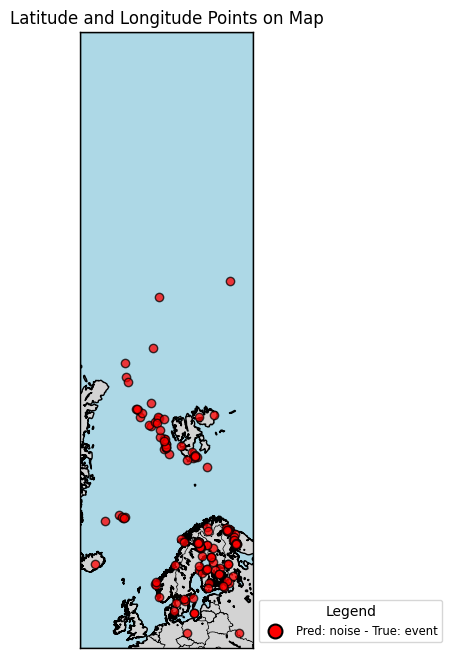

In [102]:
plot_lat_lon_on_map(filter_by_not_prediction(filter_by_true_label(extended_df, "event", use_detector = True), "event", use_detector=True), use_detector_labels=True)

In [58]:
extended_df = 

,baz_to_arces,estimated_arrival_time_arces,predicted,true,probability_detector,probability_classifier,distance,msrd,metadata,lat,lon,mag
index,,,,,,,,,,,,
0,119.051347,2015-08-01 04:45:16.467000,explosion,explosion,9.999946e-01,6.638869e-01,385.240029,0.076423,{'resource_id': 'smi:local/c866c6a4-562a-4fdc-...,67.657,33.466,1.5
1,3.637892,2020-11-07 11:36:54,noise,noise,3.745849e-37,9.198690e-11,NaN,NaN,{'est_arrivaltime_arces': '2020-11-07 11:36:54...,NaN,NaN,NaN
2,231.985558,2014-02-15 15:58:53.820000,explosion,explosion,9.999982e-01,9.961755e-01,291.985948,0.105340,{'resource_id': 'smi:local/3878051e-b42c-4d75-...,67.826,20.044,1.8
3,1.902851,2006-08-07 22:32:04,noise,noise,2.882351e-13,2.323142e-04,NaN,NaN,{'est_arrivaltime_arces': '2006-08-07 22:32:04...,NaN,NaN,NaN
4,6.214207,2017-02-24 18:22:58,noise,noise,0.000000e+00,7.371429e-16,NaN,NaN,{'est_arrivaltime_arces': '2017-02-24 18:22:58...,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
27131,1.610470,2005-04-02 01:48:34,noise,noise,0.000000e+00,0.000000e+00,NaN,NaN,{'est_arrivaltime_arces': '2005-04-02 01:48:34...,NaN,NaN,NaN
27132,231.116742,2015-11-06 00:38:59.047000,explosion,explosion,1.000000e+00,9.999770e-01,294.111151,0.087465,{'resource_id': 'smi:local/864348e6-088b-4420-...,67.784,20.080,1.5
27133,2.599202,2012-11-25 07:01:36,noise,noise,1.013640e-27,3.369809e-13,NaN,NaN,{'est_arrivaltime_arces': '2012-11-25 07:01:36...,NaN,NaN,NaN


In [118]:
#meta = pandas_df["metadata"]
eq_df = filter_by_true_label(extended_df, "earthquake")
meta = eq_df["metadata"]
#print(meta[1])
one_meta = ast.literal_eval(meta.iloc[0])
one_meta

{'resource_id': 'smi:local/ab85d753-776b-484e-9f50-a55939d2c8b2',
 'event_type': 'earthquake',
 'event_type_certainty': 'known',
 'picks': [{'resource_id': 'smi:local/160c284d-f711-421a-a542-a6d78210dc7c',
   'time': '2008-02-21T05:31:37.575000Z',
   'waveform_id': {'station_code': 'ARCES', 'channel_code': 'FE25'},
   'horizontal_slowness': 11.61,
   'horizontal_slowness_errors': {'uncertainty': 1.02},
   'backazimuth': 353.35,
   'backazimuth_errors': {'uncertainty': 0.09},
   'phase_hint': 'Pn'},
  {'resource_id': 'smi:local/9c618c29-d60d-41d8-9c61-9616d5ca7c52',
   'time': '2008-02-21T05:33:00.650000Z',
   'waveform_id': {'station_code': 'ARCES', 'channel_code': 'FT20'},
   'horizontal_slowness': 20.09,
   'horizontal_slowness_errors': {'uncertainty': 1.16},
   'backazimuth': 4.34,
   'backazimuth_errors': {'uncertainty': 0.06},
   'phase_hint': 'Sn'}],
 'origins': [{'resource_id': 'smi:local/50020e0a-e7dd-4a33-8efa-ced763ec5a99',
   'time': '2008-02-21T05:29:43.470030Z',
   'time_e

In [92]:
noise_as_eq = filter_true_vs_predicted(pandas_df, 'earthquake', 'noise')
noise_as_eq

,baz_to_arces,estimated_arrival_time_arces,predicted,true,probability_detector,probability_classifier,distance,msrd,metadata,detector_prediction,detector_true
index,,,,,,,,,,,
143,342.983436,2018-10-29 06:29:09.988000,noise,earthquake,2.463161e-06,5.203571e-07,1597.269788,0.075715,{'resource_id': 'smi:local/1421cde2-fb86-48ad-...,noise,event
153,339.272168,2015-03-18 11:12:07.865000,noise,earthquake,4.116364e-07,1.103903e-05,1117.897845,0.079946,{'resource_id': 'smi:local/b449806b-9c09-4b9d-...,noise,event
665,292.340843,2015-08-01 08:46:15.442000,noise,earthquake,2.675928e-02,8.801805e-01,1221.405150,0.104554,{'resource_id': 'smi:local/8011c67f-4705-4a08-...,noise,event
1198,355.534908,2013-06-13 07:16:38.709000,noise,earthquake,3.753801e-02,9.997017e-01,736.644402,0.075089,{'resource_id': 'smi:local/105ab842-a18b-49ed-...,noise,event
1379,355.108143,2020-03-22 09:14:11.494000,noise,earthquake,1.143429e-18,1.336388e-07,1162.171807,0.072483,{'resource_id': 'smi:local/e0842fb1-fe29-47d5-...,noise,event
...,...,...,...,...,...,...,...,...,...,...,...
25298,1.684927,2016-04-21 20:14:54.563000,noise,earthquake,1.755601e-11,5.213363e-04,1808.076273,0.072787,{'resource_id': 'smi:local/05bddfb1-05f0-43e4-...,noise,event
25638,344.921446,2018-03-29 00:17:44.712000,noise,earthquake,5.980331e-03,3.035217e-07,1650.735601,0.083265,{'resource_id': 'smi:local/38ec0170-839f-4aac-...,noise,event
25939,251.294620,2020-10-05 15:15:17.265000,noise,earthquake,1.589561e-01,8.944212e-01,82.975807,0.065868,{'resource_id': 'smi:local/0d895615-16cc-4aaa-...,noise,event


In [110]:
det_df = add_detector_pred(pandas_df, threshold = 0.4852871596813202)
det_df = add_detector_true(det_df)

true_labels = det_df['detector_true']
predicted_labels = det_df['detector_prediction']
print(det_df.head())
cm = confusion_matrix(true_labels, predicted_labels, labels=["noise", "event"])

# Convert the confusion matrix to a DataFrame for better readability
cm_df = pd.DataFrame(cm, index=["True Noise", "True Event"], columns=["Predicted Noise", "Predicted Event"])
print(cm_df)

       baz_to_arces estimated_arrival_time_arces  predicted       true  \
index                                                                    
0        119.051347   2015-08-01 04:45:16.467000  explosion  explosion   
1          3.637892          2020-11-07 11:36:54      noise      noise   
2        231.985558   2014-02-15 15:58:53.820000  explosion  explosion   
3          1.902851          2006-08-07 22:32:04      noise      noise   
4          6.214207          2017-02-24 18:22:58      noise      noise   

       probability_detector  probability_classifier    distance      msrd  \
index                                                                       
0              9.999946e-01            6.638869e-01  385.240029  0.076423   
1              3.745849e-37            9.198690e-11         NaN       NaN   
2              9.999982e-01            9.961755e-01  291.985948  0.105340   
3              2.882351e-13            2.323142e-04         NaN       NaN   
4              0.00

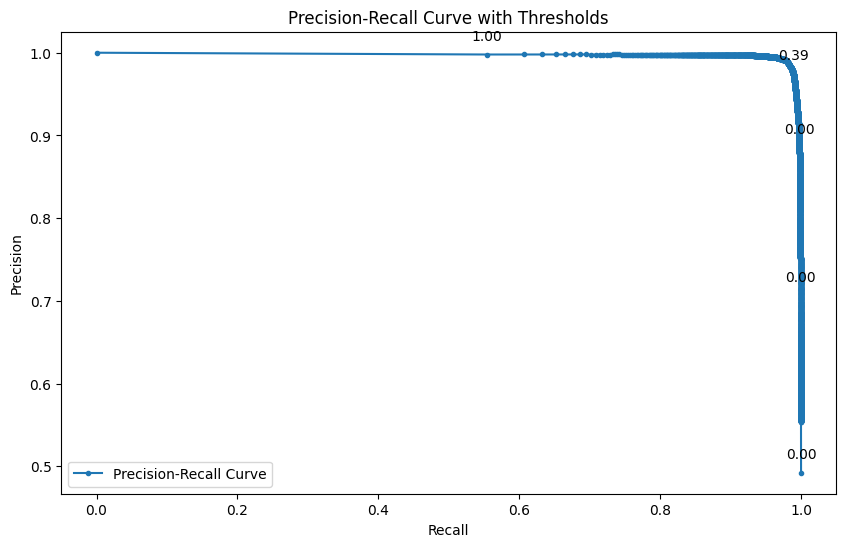

In [111]:
# Convert 'detector_true' to binary
binary_true_labels = np.where(det_df['detector_true'] == 'noise', 0, 1)

# Use 'probability_detector' as the probability scores
scores = det_df['probability_detector']

# Generate the precision-recall curve
precision, recall, thresholds = precision_recall_curve(binary_true_labels, scores)

# Plotting the curve with threshold annotations
plt.figure(figsize=(10, 6))
plt.plot(recall, precision, marker='.', label='Precision-Recall Curve')
plt.title('Precision-Recall Curve with Thresholds')
plt.xlabel('Recall')
plt.ylabel('Precision')

# Annotating selected thresholds
# Selecting a few points to annotate (avoiding clutter)
threshold_points = np.linspace(0, len(thresholds)-1, 5, dtype=int)
for i in threshold_points:
    plt.annotate(f'{thresholds[i]:.2f}', (recall[i], precision[i]), textcoords="offset points", xytext=(0,10), ha='center')

plt.legend()
plt.show()

In [109]:
beta = 1
# Calculate F1 scores for each point on the Precision-Recall curve
f1_scores = (1+(beta**2)) * (precision * recall) / (((beta**2)*precision) + recall)

# Handle the case where precision + recall might be zero (to avoid division by zero)
f1_scores = np.nan_to_num(f1_scores)

# Find the index of the maximum F1 score
max_f1_index = np.argmax(f1_scores)

# Find the corresponding threshold and F1 score
max_f1_threshold = thresholds[max_f1_index]
max_f1_score = f1_scores[max_f1_index]

max_f1_threshold, max_f1_score

NameError: name 'precision' is not defined